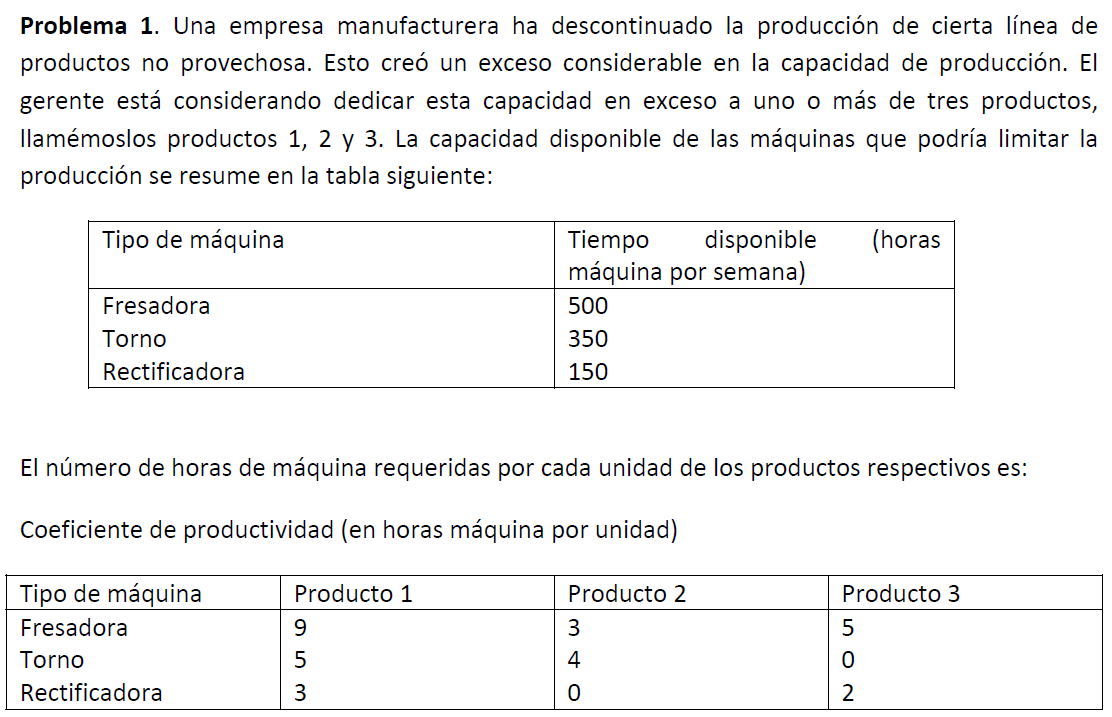

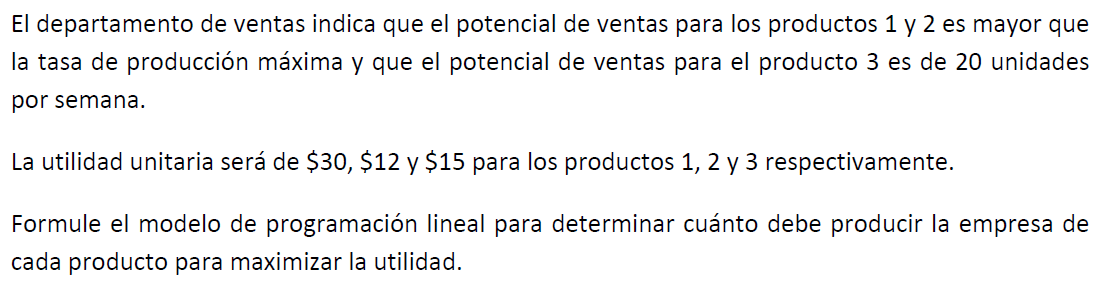

## Sets
I es el conjunto de maquinas (i = 1 es la fresadora, i = 2 es el torno, i = 3 es la rectificadora)\
J es el conjunto de productos (j = 1 es el producto 1, j = 2 es el producto 2, j = 3 es el producto 3)

In [26]:
import numpy as np
import pandas as pd
import pyomo.environ as pe
import pyomo.opt as po
import itertools

In [27]:
model = pe.ConcreteModel()

In [28]:
I = set(range(1,4))
J = set(range(1,4))

In [29]:
model.I = pe.Set(initialize = I)
model.J = pe.Set(initialize = J)

    (type: set).  This WILL potentially lead to nondeterministic behavior in
    Pyomo
    (type: set).  This WILL potentially lead to nondeterministic behavior in
    Pyomo


## Parameters
Uj es la utilidad unitaria del producto j (unidad monetaria $)\
CPij es el coeficiente de productividad indexado en i y en j (horas por unidad)\
TDi es el tiempo disponible de la maquina i (horas semanales)\
P es el número de unidades vendidas por semana del producto 3 (unidades semanales)

In [30]:
P = 20
U = {1: 30, 2: 12, 3: 15}
TD = {1: 500, 2: 350, 3: 150}
CP = {(1,1): 9, (1,2): 3, (1,3): 5,
      (2,1): 5, (2,2): 4, (2,3): 0,
      (3,1): 3, (3,2): 0, (3,3): 2}

In [31]:
model.P = pe.Param(initialize = P) #Potencial de ventas del producto 3
model.U = pe.Param(model.J, initialize = U) #Utilidad unitaria
model.TD = pe.Param(model.I, initialize = TD) #Tiempo disponible 
model.CP = pe.Param(model.I, model.J, initialize = CP) #Coeficiente de productividad

## Variables
xj es el número de unidades a fabricar semanalmente del producto j

In [32]:
model.x = pe.Var(model.J, domain = pe.NonNegativeReals)

## Objective

In [33]:
Z = sum(model.U[j] * model.x[j] for j in model.J)
model.objective = pe.Objective(sense = pe.maximize, expr = Z)
model.objective.pprint()

objective : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : 30*x[1] + 12*x[2] + 15*x[3]


## Constraints

In [34]:
model.horas_semanales = pe.ConstraintList()
for i in model.I:
    lhs = sum(model.CP[i,j] * model.x[j] for j in model.J)
    rhs = model.TD[i]
    model.horas_semanales.add(lhs <= rhs)
model.horas_semanales.pprint()

horas_semanales : Size=3, Index=horas_semanales_index, Active=True
    Key : Lower : Body                     : Upper : Active
      1 :  -Inf : 9*x[1] + 3*x[2] + 5*x[3] : 500.0 :   True
      2 :  -Inf :          5*x[1] + 4*x[2] : 350.0 :   True
      3 :  -Inf :          3*x[1] + 2*x[3] : 150.0 :   True


In [35]:
restr_PV_lhs = model.x[3]
restr_PV_rhs = model.P
model.PVentas = pe.Constraint(expr = (restr_PV_lhs <= restr_PV_rhs))
model.PVentas.pprint()

PVentas : Size=1, Index=None, Active=True
    Key  : Lower : Body : Upper : Active
    None :  -Inf : x[3] :  20.0 :   True


## Solver 

In [36]:
solver = po.SolverFactory('glpk')
results = solver.solve(model, tee = True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpp7_ilasp.glpk.raw --wglp
 C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpimvwpo1y.glpk.glp --cpxlp C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpodinku0o.pyomo.lp
Reading problem data from 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpodinku0o.pyomo.lp'...
5 rows, 4 columns, 9 non-zeros
38 lines were read
Writing problem data to 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpimvwpo1y.glpk.glp'...
29 lines were written
GLPK Simplex Optimizer 5.0
5 rows, 4 columns, 9 non-zeros
Preprocessing...
3 rows, 3 columns, 7 non-zeros
Scaling...
 A: min|aij| =  2.000e+00  max|aij| =  9.000e+00  ratio =  4.500e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 3
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (3)
*     4: obj =   1.742857143e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.0 Mb

In [37]:
for j in model.J:
    print(pe.value(model.x[j]))
print(pe.value(model.objective))

26.1904761904762
54.7619047619048
20.0
1742.8571428571436
